<h1> Extreme Gradient Boosting Regression to Colourise GrayScale images using Exemplar images 

<h2> Mounting Drive and Loading Necessary Modules 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2 
import itertools
import numpy as np
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import operator
from functools import reduce
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.feature import hog, daisy
from scipy.spatial import distance as dist

<h2> Defining standard modules for building the dataset and training the model </h2> <br>
Since the images are stored in directories and iteratively read, modularising standard functions such as loading images, quantizing them and performing feature extraction makes it easier to train the model 

In [ ]:
def load_image(path):
  img = cv2.imread(path) 
  l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))
  return l, a, b

<h3> Quantisation of Image using KMeans </h3> <br> 

The original exemplar colour images have over 11000 unique colours that can be obtained in the 224x224 pixels. However, training a model to effectively predict that many colours would be computationally hard. So we quantize an image to bring it down to a colour representation that may be trained and modelled within compute restrictions. <br>

Once we quantise the images, we use kmeans to categorise pixels into their respective colour in the reduced space using the colour map function


In [ ]:
def quantize_kmeans(a, b,ncolors, npics):
  lengthab = len(a) / npics           
  pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)  
  kmeans = KMeans(n_clusters=ncolors) 
  label=kmeans.fit(pixel)
  return label.labels_

In [ ]:
def label_to_color_map_fun(a,b,ncolors):
  w,h = np.shape(a)
  pixel = np.reshape((cv2.merge((a,b))),(w * h,2)).astype(float)
  centroids,_ = kmeans(pixel,ncolors)
  color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
  label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
  return label_to_color_map

<h3> Training the XGBoost Regressor on the LAB colour space </h3> <br>

We obtain the a and b components from each image and quantize them using kmeans to obtain the label i.e the colours associated with the pixels. We the load the l value from the colour space and merge the obtained l values and labels to generated training data for the regressor 

In [ ]:
def train_xgb(files,ncolors,num_class, npics):
  kmap_a=np.array([])
  kmap_b=np.array([])
  for f in files:
      _,a,b = load_image(f)
      kmap_a = np.concatenate([kmap_a, a.flatten()])
      kmap_b = np.concatenate([kmap_b, b.flatten()])
  w,h = np.shape(a)
  label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)

  pixel=[]
  for f in files:
      l, a, b = load_image(f)
      this_pixel = l.reshape(1,w*h).tolist()
      pixel.append(this_pixel[0]) 
                    
  pixel = reduce(operator.add, pixel)  
  pixel_mat = np.array(pixel).reshape(npics*w*h,1) 
  dtrain = xgb.DMatrix(pixel_mat, label=label)
  param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
  num_round = 10
  print('Begin xgb training')
  bst = xgb.train(param, dtrain, num_round)
  return bst

<h3> Feature extraction </h3> 

We use the gray scale version of the exemplar images to perform featur extraction. Feature extraction is performed using two popular feature descriptors: Histogram of Gradients and Daisy. 

In [ ]:
def get_feature(file):
  test_color = Image.open(file,'r')
  test_color = test_color.convert('L')
  test_gray = np.asarray(test_color.getdata(),dtype=np.float64).reshape((test_color.size[1],test_color.size[0]))
  test_gray = np.asarray(test_gray,dtype=np.uint8) 
  test_gray = Image.fromarray(test_gray,mode='L') 
  l, a, b = load_image(file)
  w,h = np.shape(a)  
  fd, hog_image = hog(test_gray, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True)

  descs, descs_img = daisy(test_gray, step=180, radius=58, rings=2, histograms=6,
                           orientations=8, visualize=True)

  feature = np.zeros((w*h,1))
  feature[:,0] = l.reshape(1,w*h)[0]

  return(feature)

<h3> XGBoost regressor with Feature extraction </h3>

Previously the XGBoost Regressor was trained with the l values obtained from the lab space of the image. We now perform feature extraction on the input image and train the Regressor using labels from the a,b values and features from feature extraction 

In [ ]:
def train_xgb_fea(files,ncolors,num_class, npics):   
  kmap_a=np.array([])
  kmap_b=np.array([])
    

  for f in files:
      _,a,b = load_image(f)
      kmap_a = np.concatenate([kmap_a, a.flatten()])
      kmap_b = np.concatenate([kmap_b, b.flatten()])

  label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)
  w,h = np.shape(a)
        
  pixel_feature = np.zeros(shape=(w*h*npics,1))
    
  for ind,f in enumerate(files):
      feature = get_feature(f)
      pixel_feature[(w*h*ind):(w*h*(ind+1)),:] = feature

  dtrain = xgb.DMatrix(pixel_feature, label=label)
  param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
  num_round = 10
  print('Begin xgb training')
  bst = xgb.train(param, dtrain, num_round)
  return bst

In [ ]:
def test_xgb_fea(file,xgb_model):     
  pixel_feature = get_feature(file)
  dtest=xgb.DMatrix(pixel_feature)
  preds = xgb_fit.predict(dtest)
  return preds

<h2> Training and Evaluating the Model for Ailurpoda-Melanoleuca </h2>

Due to the time constraint on the XGBRegressor training time, for the sake of this model, we limit our training samples to different images of the animal we are testing on 

In [ ]:
folder_dir = '/content/drive/MyDrive/Animals-151/ailuropoda-melanoleuca'
train_dir = []

for filename in os.listdir(folder_dir):
  if filename.startswith('.') or \
  filename.startswith('predict') or \
  filename.startswith('gray'): 
    continue
  train_dir.append(folder_dir +"/"+ filename)

We now extract the a and b components from the lab space to generate the colour map of the images using quantisation. In our case, we quantise the images to 128 colours 

In [ ]:
ncolors = 128
kmap_a=np.array([])
kmap_b=np.array([])
for f in train_dir:
  _,a,b = load_image(f)
  kmap_a = np.concatenate([kmap_a, a.flatten()])
  kmap_b = np.concatenate([kmap_b, b.flatten()])
h,w = np.shape(a)

In [ ]:
npics = len(train_dir)
kmap_a = kmap_a.reshape(npics*w*h,1)
kmap_b = kmap_b.reshape(npics*w*h,1)
label_to_color_map = label_to_color_map_fun(kmap_a,kmap_b,ncolors)
print(len(label_to_color_map))
ncolors = len(label_to_color_map)

119


## train xgboost model

In [ ]:
xgb_fit = train_xgb_fea(train_dir,ncolors,ncolors,npics)

Begin xgb training


In [ ]:
test_img = '/content/drive/MyDrive/Animals-151/ailuropoda-melanoleuca/1.jpg'
preds = test_xgb_fea(test_img, xgb_fit)

The colours outputed by the model are in LAB space but in order to effectively visualise and compare them we need them in RGB space. We perform this transformation with the below function

In [ ]:
def pred2color(test_img,preds,label_to_color_map,ncolors=16, saveimg = False, savename = 'test.jpg'):
    l_test, a_test, b_test = load_image(test_img)
    preds = preds.reshape(h,w)
    print(w,h)
    colors_present = [i for i in range(ncolors)]
    output_a = np.zeros((h,w))
    output_b = np.zeros((h,w))
    output_l = l_test.reshape((h,w))
    for i in range(h):
        for j in range(w):
            a,b = label_to_color_map[colors_present[int(preds[i,j])]]
            output_a[i,j] = a
            output_b[i,j] = b
    print(output_a.shape,output_b.shape,output_l.shape)
    output_img = cv2.cvtColor(cv2.merge(( np.uint8(output_l), np.uint8(output_a), np.uint8(output_b))),
                              cv2.COLOR_LAB2RGB)
    if saveimg == True:
        plt.imsave('./predict/' + savename,output_img)    
    return(output_img)

In [ ]:
output_img = pred2color(test_img,preds,label_to_color_map,ncolors=ncolors,
                        saveimg = False)

224 224
(224, 224) (224, 224) (224, 224)


We plot the predicted image and original image side by side. We notice that the predicted isn't fully representative of the original image. This is becaus the original image is represented in a colour space with over 11000 RGB combinations whereas the predicted image is represented in a colour space with 128 RGB values

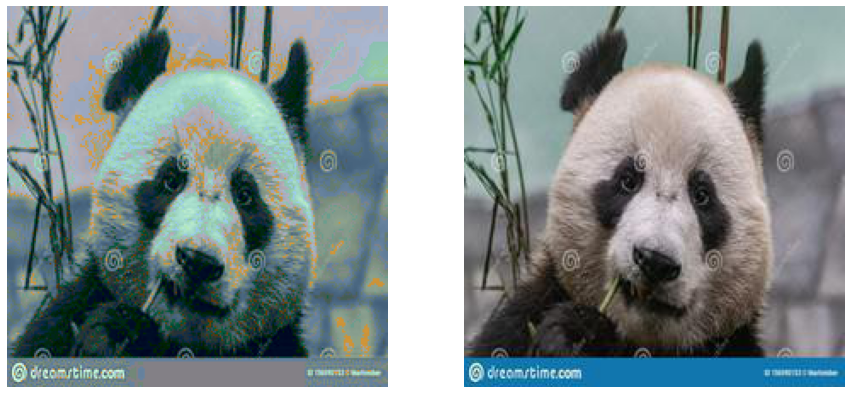

In [ ]:
import matplotlib.image as mpimg

color = output_img
true = mpimg.imread('/content/drive/MyDrive/Animals-151/ailuropoda-melanoleuca/1.jpg')
f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(color)
axarr[1].imshow(true)
axarr[0].axis('off'), axarr[1].axis('off')
plt.show()

To quantitatively analyse the images, we compare the histograms of the original image and obtained image. We use Chi-Square and Intersection to understand the relationship between histograms. The higher chi-sqaure value here is due to lack of representation for a majority of colours in the colour space due to computational constraints 

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Animals-151/acinonyx-jubatus/1.jpg")
historg = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
historg = cv2.normalize(historg, historg).flatten()

In [ ]:
histpred = cv2.calcHist([output_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
histpred = cv2.normalize(histpred, histpred).flatten()

In [ ]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_CHISQR)

11037.91454509186

In [ ]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_INTERSECT)

0.30811382138199406

<h2> Training and Evaluating the Model for Ceratotherium Simum </h2>

In [ ]:
folder_dir = '/content/drive/MyDrive/Animals-151/ceratotherium-simum'
train_dir = []

for filename in os.listdir(folder_dir):
  if filename.startswith('.') or \
  filename.startswith('predict') or \
  filename.startswith('gray'): 
    continue
  train_dir.append(folder_dir +"/"+ filename)

In [ ]:
ncolors = 128
kmap_a=np.array([])
kmap_b=np.array([])
for f in train_dir:
  _,a,b = load_image(f)
  kmap_a = np.concatenate([kmap_a, a.flatten()])
  kmap_b = np.concatenate([kmap_b, b.flatten()])
h,w = np.shape(a)

In [ ]:
npics = len(train_dir)
kmap_a = kmap_a.reshape(npics*w*h,1)
kmap_b = kmap_b.reshape(npics*w*h,1)
label_to_color_map = label_to_color_map_fun(kmap_a,kmap_b,ncolors)
print(len(label_to_color_map))
ncolors = len(label_to_color_map)

107


In [ ]:
xgb_fit = train_xgb_fea(train_dir,ncolors,ncolors,npics)

Begin xgb training


In [ ]:
test_img = '/content/drive/MyDrive/Animals-151/ceratotherium-simum/30.jpg'
preds = test_xgb_fea(test_img, xgb_fit)

In [ ]:
output_img_rh = pred2color(test_img,preds,label_to_color_map,ncolors=ncolors,
                        saveimg = False)

224 224
(224, 224) (224, 224) (224, 224)


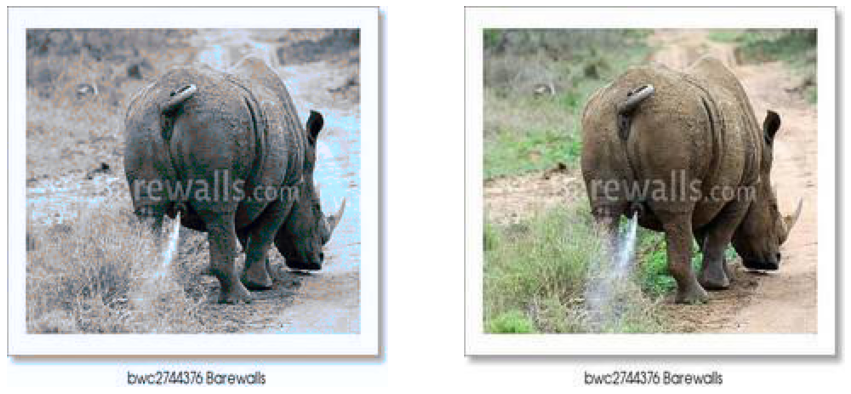

In [ ]:
import matplotlib.image as mpimg

color = output_img_rh
true = mpimg.imread('/content/drive/MyDrive/Animals-151/ceratotherium-simum/30.jpg')
f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(color)
axarr[1].imshow(true)
axarr[0].axis('off'), axarr[1].axis('off')
plt.show()

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Animals-151/ceratotherium-simum/30.jpg')
historg = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
historg = cv2.normalize(historg, historg).flatten()

In [ ]:
histpred = cv2.calcHist([output_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
histpred = cv2.normalize(histpred, histpred).flatten()

In [ ]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_CHISQR)

7548.689000046108

In [ ]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_INTERSECT)

1.6758004450966837

<h2> Training and Evaluating the Model for Dasypus-Novemcinctus </h2>

In [ ]:
folder_dir = '/content/drive/MyDrive/Animals-151/dasypus-novemcinctus'
train_dir = []

for filename in os.listdir(folder_dir):
  if filename.startswith('.') or \
  filename.startswith('predict') or \
  filename.startswith('gray'): 
    continue
  train_dir.append(folder_dir +"/"+ filename)

In [ ]:
ncolors = 128
kmap_a=np.array([])
kmap_b=np.array([])
for f in train_dir:
  _,a,b = load_image(f)
  kmap_a = np.concatenate([kmap_a, a.flatten()])
  kmap_b = np.concatenate([kmap_b, b.flatten()])
h,w = np.shape(a)

In [ ]:
npics = len(train_dir)
kmap_a = kmap_a.reshape(npics*w*h,1)
kmap_b = kmap_b.reshape(npics*w*h,1)
label_to_color_map = label_to_color_map_fun(kmap_a,kmap_b,ncolors)
print(len(label_to_color_map))
ncolors = len(label_to_color_map)

115


In [ ]:
xgb_fit = train_xgb_fea(train_dir,ncolors,ncolors,npics)

Begin xgb training


In [ ]:
test_img = '/content/drive/MyDrive/Animals-151/dasypus-novemcinctus/29.jpg'
preds = test_xgb_fea(test_img, xgb_fit)

In [42]:
output_img_ra = pred2color(test_img,preds,label_to_color_map,ncolors=ncolors,
                        saveimg = False)

224 224
(224, 224) (224, 224) (224, 224)


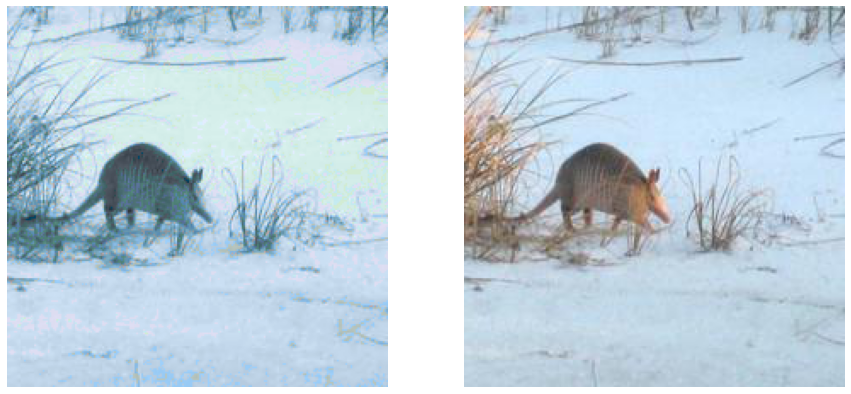

In [43]:
color = output_img_ra
true = mpimg.imread('/content/drive/MyDrive/Animals-151/dasypus-novemcinctus/29.jpg')
f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(color)
axarr[1].imshow(true)
axarr[0].axis('off'), axarr[1].axis('off')
plt.show()

In [44]:
image = cv2.imread('/content/drive/MyDrive/Animals-151/dasypus-novemcinctus/29.jpg')
historg = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
historg = cv2.normalize(historg, historg).flatten()

In [45]:
histpred = cv2.calcHist([output_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
histpred = cv2.normalize(histpred, histpred).flatten()

In [46]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_CHISQR)

4.8011137355973865

In [47]:
cv2.compareHist(histpred, historg, cv2.HISTCMP_INTERSECT)

0.3618648607916839